In [1]:
import numpy as np
import astropy
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.table import Table,vstack, Column,join
import wget
import astropy.units as u
from numpy.ma import masked
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
def calcStats(photoz, specz):
    cut = np.logical_and(photoz >= 0, specz >= 0.)
    #print('NGD: {0}'.format(cut.sum()))
    dz = photoz - specz
    abs_dz = np.abs(dz)/(1+specz)

    p90 = (abs_dz < np.percentile(abs_dz, 90.))
    sigma_90 = np.sqrt(np.sum((dz[p90]/(1+specz[p90]))**2) / float(len(dz)))

    bias = np.nanmedian(dz[cut]/(1+specz[cut]))
    ol1 = (abs_dz > 0.15)
    nmad = 1.48 * np.median( np.abs(dz[cut] - np.median(dz[cut])) / (1+specz[cut]))
    ol2 = (abs_dz > (3*nmad))
    OLF1 = np.sum( ol1[cut] ) / float(len(dz[cut]))
    OLF2 = np.sum( ol2[cut] ) / float(len(dz[cut]))
    
    ol1_s, ol2_s = np.invert(ol1), np.invert(ol2)

    return nmad, sigma_90, OLF1, bias

In [6]:
url=f'https://s3.amazonaws.com/grizli-v2/JwstMosaics/v7/primer-cosmos-west-grizli-v7.0_phot.fits'
filename=wget.download(url)

100% [......................................................................] 229651200 / 229651200

# DAWN Comparison Only


## Opening Files

In [4]:
#photometric catalogues
hdul= fits.open('gdn-grizli-v7.0_phot.fits', memmap=True,formats='fits')
abellclu= fits.open('abell2744clu-grizli-v7.0_phot.fits', memmap=True,formats='fits')
gdn = Table.read(hdul)
abell = Table.read(abellclu)


In [3]:
#eazy catalogues
gdn_e= fits.open('MPhys/eazy_comp/gdn-grizli-v7.3-fix.eazypy.zout.fits', memmap=True,formats='fits')
abell_e= fits.open('MPhys/eazy_comp/abell2744clu-grizli-v7.2-fix.eazypy.zout.fits', memmap=True,formats='fits')
gdn_eazy = Table.read(gdn_e)
abell_eazy = Table.read(abell_e)
primer = Table.read('MPhys/eazy_comp/cosmos_primer_aurora_050923_phot.cat',format = 'ascii.commented_header')

In [320]:
gdn_eazy

id,ra,dec,z_spec,nusefilt,z_ml,z_ml_chi2,z_ml_risk,lc_min,lc_max,z_phot,z_phot_chi2,z_phot_risk,z_min_risk,min_risk,z_raw_chi2,raw_chi2,z025,z160,z500,z840,z975,restU,restU_err,restB,restB_err,restV,restV_err,restJ,restJ_err,dL,mass,sfr,Lv,LIR,energy_abs,Lu,Lj,L1400,L2800,LHa,LOIII,LHb,LOII,MLv,Av,lwAgeV,mass_p,sfr_p,Lv_p,LIR_p,energy_abs_p,Lu_p,Lj_p,L1400_p,L2800_p,LHa_p,LOIII_p,LHb_p,LOII_p,Av_p,ssfr_p,rest120,rest120_err,rest121,rest121_err,rest156,rest156_err,rest157,rest157_err,rest158,rest158_err,rest159,rest159_err,rest160,rest160_err,rest414,rest414_err,rest415,rest415_err,rest416,rest416_err
,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,Mpc,solMass,solMass / yr,solLum,solLum,solLum,solLum,solLum,solLum,solLum,solLum,solLum,solLum,solLum,solMass / solLum,,Gyr,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,float64,int64,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
1,189.38240900634372,62.11320686605782,-1.0,0,-1.0,-1.0,-1.0,43188281021088.9,0.0,-1.0,-1.0,-1.0,0.01,0.0,0.01,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0e+00,-9.00e+29,-900000000000000046043660025856.000,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-900000000000000046043660025856.00,-900000000000000046043660025856.00,-900000000000000046043660025856.00,-9.00e+29 .. -9.00e+29,-900000000000000046043660025856.000 .. -900000000000000046043660025856.000,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-900000000000000046043660025856.00 .. -900000000000000046043660025856.00,-9.00e+29 .. -9.00e+29,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,189.35570806906557,62.113240399803495,-1.0,0,-1.0,-1.0,-1.0,43188281021088.9,0.0,-1.0,-1.0,-1.0,0.01,0.0,0.01,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0e+00,-9.00e+29,-900000000000000046043660025856.000,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-900000000000000046043660025856.00,-900000000000000046043660025856.00,-900000000000000046043660025856.00,-9.00e+29 .. -9.00e+29,-900000000000000046043660025856.000 .. -900000000000000046043660025856.000,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-900000000000000046043660025856.00 .. -900000000000000046043660025856.00,-9.00e+29 .. -9.00e+29,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,189.3330736250277,62.113264797756706,-1.0,0,-1.0,-1.0,-1.0,43188281021088.9,0.0,-1.0,-1.0,-1.0,0.01,0.0,0.01,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0e+00,-9.00e+29,-900000000000000046043660025856.000,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-900000000000000046043660025856.00,-900000000000000046043660

In [319]:
gdn_eazy = gdn_eazy['id','ra','dec','z_phot','z_phot_chi','z_phot_risk']
abell_eazy = abell_eazy['id','ra','dec','z_phot','z_phot_chi','z_phot_risk']

KeyError: 'z_phot_chi'

In [ ]:
primer

In [316]:
eazy_outputs = vstack([gdn_eazy,abell_eazy,primer])

In [ ]:
bad_zspec = np.ones(len(eazy_outputs))
for i in range(len(eazy_outputs)):
    if eazy_outputs['z_spec'][i]<=0:
        bad_zspec[i]=0
joined_z_spec = eazy_outputs[np.array(bad_zspec,dtype=bool)]

bad_zphot = np.ones(len(joined_z_spec))
for i in range(len(joined_z_spec)):
    if np.isnan(joined_z_spec['z_phot'][i]):
        bad_zphot[i]=0
joined_final = joined_z_spec[np.array(bad_zphot,dtype=bool)]

In [317]:
eazy_outputs.write('MPhys/eazy_comp/eazy_outputs_all.fits',format='fits')


KeyboardInterrupt



 ### Spectroscopic Redshifts

In [63]:
specz = Table.read('MPhys/eazy_comp/final_skymatched_catalogue_excel_inc_no_photometry.fits',format='fits')

goodz=np.ones(len(specz))
for i in range(len(specz)):
    if np.ma.is_masked(specz['z_spec'][i]):
        goodz[i]=0
specz = specz[np.array(goodz,dtype=bool)]

In [101]:
goods_specz = np.zeros(len(specz))
abells_specz = np.zeros(len(specz))
primer_specz = np.zeros(len(specz))
for i in range(len(specz)):
    if specz['field'][i]=='gdn          'or specz['field'][i]=='gds          ':
       
        goods_specz[i]=1
    elif specz['field'][i]=='abells2744clu':
        abells_specz[i]=1
    elif specz['field'][i]=='cosmos_east  ' or specz['field'][i]=='cosmos_west  ':
        primer_specz[i]=1
#
goods_z = specz[np.array(goods_specz,dtype=bool)]        
abells_z = specz[np.array(abells_specz,dtype=bool)]
primer_z = specz[np.array(primer_specz,dtype=bool)]

## GOODS

In [6]:
joined = join(gdn_eazy,gdn,keys='id')

In [8]:
joined_cut = joined['id','ra_1','dec_1','z_spec','z_phot'] #goods


In [9]:
#get rid of bad phot values
joined_cut['z_phot'][joined_cut['z_phot'] <= 0] = np.nan
cat=np.ones(len(joined_cut))
for i in range(len(joined_cut)):
    if np.isnan(joined_cut['z_phot'][i]):
        cat[i]=0
cat_good = np.array(cat,dtype=bool)
joined_cut_phot=joined_cut[cat_good]

In [55]:
#skymatch goods 

ra1=joined_cut['ra_1']

dec1=joined_cut['dec_1']
ra2=goods_z['ra']
dec2=goods_z['dec']

goods_eazy_cat = SkyCoord(ra=ra1, dec=dec1)#dawn
goods_specz_cat = SkyCoord(ra=ra2*u.degree, dec=dec2*u.degree)#candels

max_sep = 0.1 * u.arcsec
idx, d2d, d3d = goods_eazy_cat.match_to_catalog_sky(goods_specz_cat)#catalog = candels information
idx_eazy_g, d2d_eazy_g, d3d_eazy_g = goods_specz_cat.match_to_catalog_sky(goods_eazy_cat)


37890 6157


In [59]:
for i in range(len(goods_specz_cat)):
    if abs(ra2[i]-ra1[idx_eazy_g[i]])<0.1:
        joined_cut['z_spec'][idx[i]]=goods_z['z_spec'][i]


## Abell2744

In [60]:
joined_ab = join(abell_eazy,abell,keys='id')


In [111]:
joined_ab=joined_ab['id','ra_1','dec_1','z_spec','z_phot']

In [112]:
#ABELLS
joined_ab['z_phot'][joined_ab['z_phot'] <= 0] = np.nan
cat_ab=np.ones(len(joined_ab))
for i in range(len(joined_ab)):
    if np.isnan(joined_ab['z_phot'][i]):
        cat_ab[i]=0
cat_good_ab = np.array(cat_ab,dtype=bool)
joined_ab_phot=joined_ab[cat_good_ab]

In [113]:
#skymatch abell 

ra1=joined_ab['ra_1']

dec1=joined_ab['dec_1']
ra2=abells_z['ra']
dec2=abells_z['dec']

abell_eazy_cat = SkyCoord(ra=ra1, dec=dec1)#dawn
abell_specz_cat = SkyCoord(ra=ra2*u.degree, dec=dec2*u.degree)#candels

max_sep = 0.1 * u.arcsec
idx, d2d, d3d = abell_eazy_cat.match_to_catalog_sky(abell_specz_cat)#catalog = candels information
idx_eazy_a, d2d_eazy_a, d3d_eazy_a = abell_specz_cat.match_to_catalog_sky(abell_eazy_cat)


In [114]:
for i in range(len(abell_specz_cat)):
    if abs(ra2[i]-ra1[idx_eazy_a[i]])<0.1:
        joined_ab['z_spec'][idx[i]]=abells_z['z_spec'][i]


### Combining Abell and GOODS

In [124]:
joined_ab.add_column('abells2744', name='field')
joined_cut.add_column('goods', name='field')

In [125]:
joined = vstack([joined_cut,joined_ab])

In [128]:
bad_zspec = np.ones(len(joined))
for i in range(len(joined)):
    if joined['z_spec'][i]<=0:
        bad_zspec[i]=0
joined_z_spec = joined[np.array(bad_zspec,dtype=bool)]

bad_zphot = np.ones(len(joined_z_spec))
for i in range(len(joined_z_spec)):
    if np.isnan(joined_z_spec['z_phot'][i]):
        bad_zphot[i]=0
joined_final = joined_z_spec[np.array(bad_zphot,dtype=bool)]

# Plotting

In [44]:
def useLatex():
    # Setup to use LaTeX in figure labels
    plt.rcParams.update({
    "text.usetex": True,
    "font.family": "lmodern",
    "text.latex.preamble": r"\usepackage{amsmath, amssymb}"})
    plt.rcParams.update({'font.size': 14})

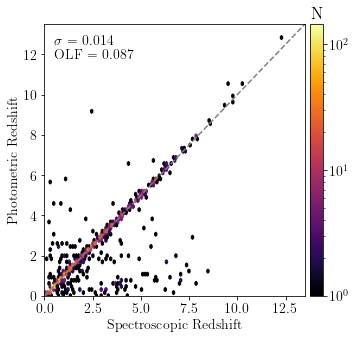

In [134]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
xs = np.linspace(0,15,10)
useLatex()
im1=ax.hexbin(joined_final['z_spec'],joined_final['z_phot'],bins='log',cmap = 'inferno')
stats=calcStats(joined_final['z_phot'],joined_final['z_spec'])
ax.text(0.5, 13,f'$\sigma$ = {stats[0]:.3f} \n OLF = {stats[2]:.3f}',  fontsize=14,
        verticalalignment='top')
ax.plot(xs,xs,linestyle='--',color='grey')
ax.set_ylim(0,13.5)
ax.set_xlim(0,13.5)
ax.set_ylabel('Photometric Redshift')
ax.set_xlabel('Spectroscopic Redshift')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.075)
cb = fig.colorbar(im1, cax=cax, orientation='vertical')
cb.ax.set_title('N')
plt.savefig('MPhys/eazy_comp/dawn_comp_only.pdf')

### Skymatching

In [185]:
primer = Table.read('MPhys/eazy_comp/cosmos_primer_aurora_050923_phot.cat',format = 'ascii.commented_header')


In [193]:
primer['zspec']

0.68
-99.0
-99.0
-99.0
-99.0
-99.0
-99.0
-99.0
-99.0
-99.0
-99.0


In [192]:
p_phot = np.ones(len(primer))
for i in range(len(primer)):
    if primer['zmed'][i]<=0:
        p_phot[i]=0
primer= primer[np.array(p_phot,dtype=bool)]

In [194]:
p_spec = np.ones(len(primer))
for i in range(len(primer)):
    if primer['zspec'][i]<=0:
        p_spec[i]=0
primer= primer[np.array(p_spec,dtype=bool)]

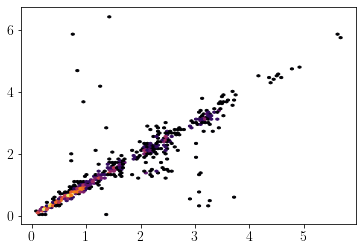

In [197]:
plt.hexbin(primer['zspec'],primer['zmed'],bins='log',cmap = 'inferno')


In [198]:
#matching jwst and candels
ra1=primer_z['ra']

dec1=primer_z['dec']
ra2=primer['ra']
dec2=primer['dec']


In [199]:
primer_mphys_cat = SkyCoord(ra=ra1*u.degree, dec=dec1*u.degree)#dawn
primer_cat = SkyCoord(ra=ra2*u.degree, dec=dec2*u.degree)#candels


In [245]:
max_sep = 0.01 * u.arcsec
idx, d2d, d3d = primer_mphys_cat.match_to_catalog_sky(primer_cat)#catalog = candels information
idx_mphys, d2d_mphys, d3d_mphys = primer_cat.match_to_catalog_sky(primer_mphys_cat)


In [246]:
primer_z['zphot']=np.zeros(len(primer_z))

In [282]:

for i in range(len(primer_cat)):
    if abs(ra2[i]-ra1[idx_mphys[i]])<0.01 and abs(dec2[i]-dec1[idx_mphys[i]])<0.01:
        
        primer_z['zphot'][idx_mphys[i]]=primer['zspec'][idx[i]]


In [283]:
print(idx)
print(idx_mphys) 
print(len(idx),len(idx_mphys))

[   9   15   15 ... 1256 1252 1252]
[   1    0    0 ... 2102 2104 2113]
4469 1257


In [284]:
primer_z

field,id,ra,dec,z_spec,zphot
bytes13,int64,float64,float64,float64,float64
cosmos_east,328804,150.13938496687632,2.183131113787984,0.6511,0.7466
cosmos_east,328909,150.13096146278866,2.183069579033965,0.3533,0.927
cosmos_east,328945,150.12926143424687,2.1842758748862767,0.972,0.0
cosmos_east,329150,150.14647604813547,2.1858829302691194,0.9274,0.927
cosmos_east,329182,150.1625958244059,2.18639442892871,0.8032,0.0
cosmos_east,329274,150.16308187616124,2.1869714658039725,0.9281,0.0
cosmos_east,329297,150.15453272438347,2.1871571930186313,3.2692,0.0
cosmos_east,329323,150.15659590196873,2.1870607550950236,0.7995,0.0
cosmos_east,329436,150.11924825528573,2.1878886944184717,0.878,0.0


In [253]:
bad_zphot = np.ones(len(primer_z))
for i in range(len(primer_z)):
    if primer_z['zphot'][i]<=0:
        bad_zphot[i]=0
primer_goodz = primer_z[np.array(bad_zphot,dtype=bool)]

In [254]:
primer_goodz

field,id,ra,dec,z_spec,zphot
bytes13,int64,float64,float64,float64,float64
cosmos_east,328804,150.13938496687632,2.183131113787984,0.6511,0.7466
cosmos_east,328909,150.13096146278866,2.183069579033965,0.3533,0.927
cosmos_east,329150,150.14647604813547,2.1858829302691194,0.9274,0.927
cosmos_east,329485,150.1462854327507,2.187827059637717,0.737,0.728
cosmos_east,329532,150.15171975070805,2.1886720136492155,0.9269,0.927
cosmos_east,329653,150.11811210616924,2.1893846734337807,0.3515,0.395
cosmos_east,329725,150.12802536535955,2.1904091210478827,0.6013,0.927
cosmos_east,329952,150.14408188498217,2.1920710285660605,0.395,0.3815
cosmos_east,330001,150.12883268918478,2.193218110891878,0.8783,0.666


In [261]:
p_fields = primer_goodz['field']

In [262]:
primer_goodz.remove_column('field')

In [263]:
primer_goodz.add_column('primer_cosmos', name='field')

In [264]:
primer_goodz.rename_column('zphot','z_phot')

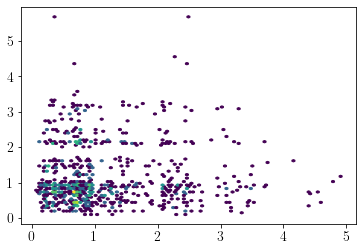

In [277]:
plt.hexbin(primer_goodz['z_spec'], primer_goodz['z_phot'],bins='log')

In [265]:
joined.rename_column('ra_1','ra')
joined.rename_column('dec_1','dec')

KeyError: 'Column ra_1 does not exist'

# Primer

In [285]:
primer = Table.read('MPhys/eazy_comp/primer_cosmos_skymatched_good_spec.fits',format='fits')

In [287]:
primer

field,id_1,ra_1,dec_1,z_spec,ID_2,cfht_u,f435w,HSC_G,f606w,HSC_R,f814w,f090w,f115w,f150w,f200w,f277w,f356w,f410m,f444w,cfht_u_err,f435w_err,HSC_G_err,f606w_err,HSC_R_err,f814w_err,f090w_err,f115w_err,f150w_err,f200w_err,f277w_err,f356w_err,f410m_err,f444w_err,ra_2,dec_2,x,y,mag356,z_cd_peg,z_fc_pca,z_fc_peg,z_dm_bc,z_dm_peg4,z_dm_peg,z_rm,chi_cd_peg,chi_fc_pca,chi_fc_peg,chi_dm_bc,chi_dm_peg4,chi_dm_peg,chi_rm,zmed,cmed,zspec,zcat,zsig,ebv,m1500_iso,u_iso,v_iso,j_iso,mass_iso,sfr_iso,ssfr_iso,flux_auto,total_factor,MassTot,Separation
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,arcsec
bytes13,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float64,float64,float64,float64,float64,float64,float32,bytes8,float64,float32,float32,float32,float32,float32,float32,float64,float32,float64,float64,float64,float64
cosmos_east,328804,150.13938496687632,2.183131113787984,0.6511,6813.0,0.3498609,0.3991798,0.4162112,0.55031,0.6722396,0.8906493,0.8600382,1.054209,1.038493,1.091829,1.191685,0.8722324,0.7270402,0.6321133,0.03498609,0.027880356917849295,0.041621120000000005,0.027515865,0.06722396000000001,0.044532465,0.043001910000000004,0.05271045,0.05192465000000001,0.05459145,0.059584250000000005,0.043611620000000004,0.036352010000000004,0.031605665,150.13938428,2.1831256053,11425.874,4308.8735,24.048419462581535,0.746,0.635,0.714,0.6782,0.7221,0.7135,0.7,17.46345,5.56,13.04,3.65945,5.70325,4.52829,6.037282376028696,0.7135000228881836,5.703249931335449,-99.0,-,0.019320421184196853,0.175,-17.674,-17.994,-18.507,-18.831,8.30933,0.287068,-8.02226,0.9499418,1.2101028222396792,8.392152273815695,0.019983909116805927
cosmos_east,329150,150.14647604813547,2.1858829302691194,0.9274,7712.0,0.5905077,0.8411087,0.8615311,1.27369,1.44475,3.297147,3.73867,6.323266,8.172831,10.26504,12.68685,11.92563,10.58253,9.213173,0.05905077,0.042055435,0.08615311,0.0636848,0.144475,0.16485735,0.1869335,0.31616330000000004,0.40864155,0.513252,0.6343425,0.5962815,0.5291265,0.46065865,150.14646789,2.1858805292,10576.46,4639.4761,21.208796672586175,1.027,0.8082,1.003,0.8031,0.8912,0.8688,0.9,26.1094,11.79,26.38,3.68425,20.2916,11.04,12.810292811037574,0.8912000060081482,12.810293197631836,-99.0,-,0.04267976784439823,0.125,-18.799,-19.689,-20.897,-21.842,10.1703,0.559847,-9.61046,12.06711,1.1242928046568608,10.221179431238768,0.030594384305217683
cosmos_east,329484,150.14672283377013,2.1874057206626207,0.7134,7906.0,0.3790682,0.4790797,0.8292814,1.47871,2.010197,4.587571,5.63658,9.411654,13.01363,17.47118,21.89489,18.26152,14.5791,13.18863,0.03790682000000001,0.039716056003689014,0.08292814,0.0739359,0.2010197,0.22937855,0.28182900000000005,0.4705827,0.6506815,0.8735590000000001,1.0947445,0.9130760000000001,0.728955,0.6594315000000001,150.14672671,2.1873879088,10545.4268,4820.3633,20.74615769184838,0.645,0.6548,0.651,0.707,0.6907,0.7111,0.7,10.83871,5.14,6.58,2.16107,3.37268,3.82118,4.604497659759982,0.6906999945640564,4.60449743270874,-99.0,-,0.015667549452012118,0.25,-17.44,-19.05,-20.597,-21.754,10.2996,0.4507,-9.84886,18.58254,1.130643378353317,10.352925643620196,0.06562136637096168
cosmos_east,329485,150.1462854327507,2.187827059637717,0.737,6974.0,0.2274608,0.6864324,0.7946454,2.88267,3.152237,12.22739,16.13575,30.29076,49.45492,75.55223,102.0066,87.29472,70.76984,63.11963,0.022746080000000002,0.039716056003689014,0.07946454,0.14413375,0.3152237,0.6113695,0.8067875000000001,1.514538,2.4727460000000003,3.7776115,5.1003300000000005,4.364736,3.538492,3.1559815,150.14627512,2.1878212409,10599.5791,4872.3623,19.04753005924155,1.152,0.5914,0.601,0.7215,0.6444,0.6431,0.6,71.28285,42.9,60.66,13.1811,44.3611,35.5942,56.999854

In [288]:
primer = primer['id_1','ra_1','dec_1','z_spec','zmed']

In [289]:
primer.rename_column('ra_1','ra')
primer.rename_column('dec_1','dec')
primer.rename_column('id_1','id')
primer.rename_column('zmed','zphot')

In [290]:
primer.add_column('primer_cosmos', name='field')

In [294]:
primer.rename_column('zphot','z_phot')

(0.0, 14.0)

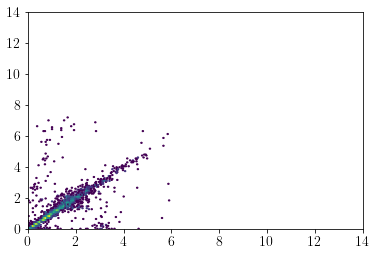

In [313]:
plt.hexbin(primer['z_spec'],primer['z_phot'],bins='log')
plt.ylim(0,14)
plt.xlim(0,14)

id,ra,dec,z_spec,z_phot,field
,deg,deg,,,
int32,float64,float64,float64,float32,str10
1,189.38240900634372,62.11320686605782,-1.0,nan,goods
2,189.35570806906557,62.113240399803495,-1.0,nan,goods
3,189.3330736250277,62.113264797756706,-1.0,nan,goods
4,189.29783277410252,62.11329542646019,-1.0,nan,goods
5,189.27491679168676,62.11331083737486,-1.0,nan,goods
6,189.271313022017,62.113312551626585,-1.0,nan,goods
7,189.25467748544887,62.11332072406936,-1.0,nan,goods
8,189.20548545286294,62.11333254729769,-1.0,nan,goods


In [304]:
bad_zphot = np.ones(len(joined))
for i in range(len(joined)):
    if np.isnan(joined['z_phot'][i]):
        bad_zphot[i]=0
joined_goodz = joined[np.array(bad_zphot,dtype=bool)]

In [305]:
bad_zspec = np.ones(len(joined_goodz))
for i in range(len(joined_goodz)):
    if joined_goodz['z_spec'][i]<=0:
        bad_zspec[i]=0
joined_catsz = joined_goodz[np.array(bad_zspec,dtype=bool)]

(0.0, 14.0)

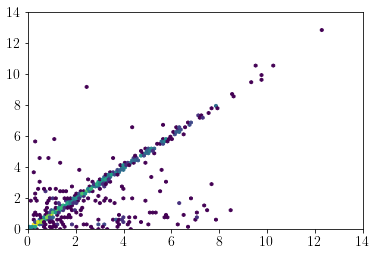

In [314]:
plt.hexbin(joined_catsz['z_spec'],joined_catsz['z_phot'],bins='log')
plt.ylim(0,14)
plt.xlim(0,14)

In [307]:
all_cats = vstack([joined_catsz , primer])

In [308]:
all_cats.write('MPhys/eazy_comp/all_cats.fits',format='fits',overwrite=True)

In [309]:
all_cats

id,ra,dec,z_spec,z_phot,field
,deg,deg,,,
int64,float64,float64,float64,float64,str13
1281,189.3013620888797,62.14090780989422,3.357845,3.326979637145996,goods
1324,189.23574289700358,62.14119451937556,6.735945,6.713842391967773,goods
1346,189.24431281110992,62.141180178329236,1.4326375722885132,1.4338405132293701,goods
1694,189.28108319194547,62.14274192500467,1.677216,1.8336530923843384,goods
1921,189.2308654202508,62.14430462480496,2.084772,2.153111219406128,goods
1998,189.31296510095154,62.144566139356755,2.825838,2.750148057937622,goods
2006,189.3003318133674,62.14470308701523,2.718341,2.7494354248046875,goods
2028,189.27482640458274,62.144754282326424,3.933643,4.0724568367004395,goods


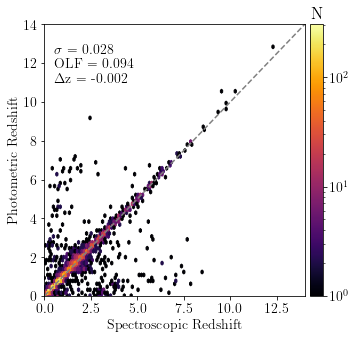

In [310]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
xs = np.linspace(0,15,10)
useLatex()
im1=ax.hexbin(all_cats['z_spec'],all_cats['z_phot'],bins='log',cmap = 'inferno')
stats=calcStats(all_cats['z_phot'],all_cats['z_spec'])
ax.text(0.5, 13,f'$\sigma$ = {stats[0]:.3f} \n OLF = {stats[2]:.3f} \n $\Delta$z = {stats[3]:.3f}',  fontsize=14,
        verticalalignment='top')
ax.plot(xs,xs,linestyle='--',color='grey')
ax.set_ylim(0,14)
ax.set_xlim(0,14)
ax.set_ylabel('Photometric Redshift')
ax.set_xlabel('Spectroscopic Redshift')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.075)
cb = fig.colorbar(im1, cax=cax, orientation='vertical')
cb.ax.set_title('N')
plt.savefig('MPhys/eazy_comp/dawn_excels_comp.pdf')

In [5]:
gpz_out = Table.read('MPhys/eazy_comp/gpz_comp.cat',format='ascii')
#gpz_out.rename_column('col1','id')
gpz_out_dawn =Table.read('MPhys/eazy_comp/gpz_comp_dawn.cat',format='ascii')

In [4]:
all_cats = Table.read('MPhys/eazy_comp/all_cats.fits',format='fits')

In [18]:
print(len(gpz_out),len(all_cats))


4260 5399


In [19]:

j = join(gpz_out,all_cats,keys='id')

In [7]:
gpz_out_dawn.rename_column('col1','id')
dawn= join(gpz_out_dawn,all_cats,keys='id')

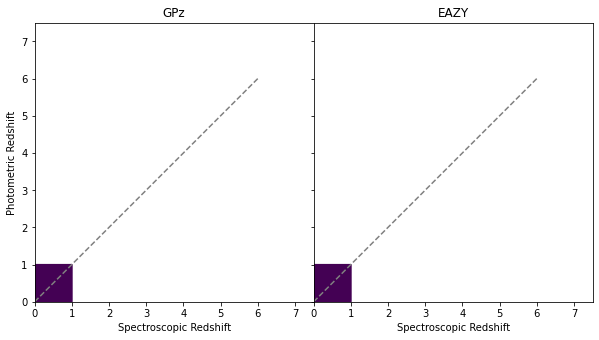

In [11]:
fig,ax = plt.subplots(1,2,sharey=True,figsize=(10,10))
#useLatex()
ax[0].hexbin(dawn['z_spec'],dawn['col2'],bins='log')
ax[1].hexbin(dawn['z_spec'],dawn['z_phot'],bins='log')
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[0].set_xlim(0,7.5)
ax[1].set_xlim(0,7.5)
ax[0].set_ylim(0,7.5)
ax[1].set_ylim(0,7.5)
#stats_gpz=calcStats(j['col2'],j['z_spec'])
#stats_eazy=calcStats(j['z_phot'],j['z_spec'])
#ax[0].text(0.3, 7.3,f'$\sigma$ = {stats_gpz[0]:.3f} \nOLF = {stats_gpz[2]:.3f} \n$\Delta$z = {stats_gpz[3]:.3f}',  fontsize=14,
#        verticalalignment='top')
#ax[1].text(5, 7.3,f'$\sigma$ = {stats_eazy[0]:.3f} \nOLF = {stats_eazy[2]:.3f} \n$\Delta$z = {stats_eazy[3]:.3f}',  fontsize=14,
#        verticalalignment='top')
x = np.linspace(0,6,8)
ax[0].plot(x,x,color ='grey',linestyle ='--')
ax[1].plot(x,x,color ='grey',linestyle ='--')
ax[0].set_title('GPz')
ax[1].set_title('EAZY')
ax[0].set_ylabel('Photometric Redshift')
ax[0].set_xlabel('Spectroscopic Redshift')
ax[1].set_xlabel('Spectroscopic Redshift')
plt.subplots_adjust(wspace=0, hspace=None)
#plt.savefig('MPhys/eazy_comp/eazy_vs_gpz_dawn.pdf',bbox_inches='tight')